# 08-02. 합성곱 신경망을 사용한 이미지 분류

In [ ]:
# 패션 MNIST 데이터 불러오기

from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0  # 3차원 배열로 변환
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 합성곱 신경망 모델 만들기


In [ ]:
# 첫 번째 합성곱-풀링 층 추가

model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))  # 합성곱 층 추가(입력의 차원을 3차원으로 설정)
model.add(keras.layers.MaxPooling2D(2))  # 풀링 층 추가

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 두번째 합성곱-풀링 층 추가

model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))  # 필터의 개수를 64개로 증가
model.add(keras.layers.MaxPooling2D(2))

In [ ]:
# 밀집층과 출력층 추가

model.add(keras.layers.Flatten())  # 출력층에서의 확률 계산을 위해 3차원 배열을 1차원으로 변환
model.add(keras.layers.Dense(100, activation='relu'))  # 출력층 직전 하나의 밀집 은닉층 추가
model.add(keras.layers.Dropout(0.4))  # 과대적합 방지
model.add(keras.layers.Dense(10, activation='softmax'))  # 출력층

In [ ]:
# 모델 구조 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

- 첫번째 합성곱 층에서 깊이가 32가 되고 풀링 층을 거치며 가로세로의 크기가 줄어드는 것을 볼 수 있다.
- 필터의 크기가 (3, 3, 1)이기 때문에 첫번째 합성곱 층의 파라미터는 총 3 x 3 x 1 x 32 + 32 = 320개가 된다.

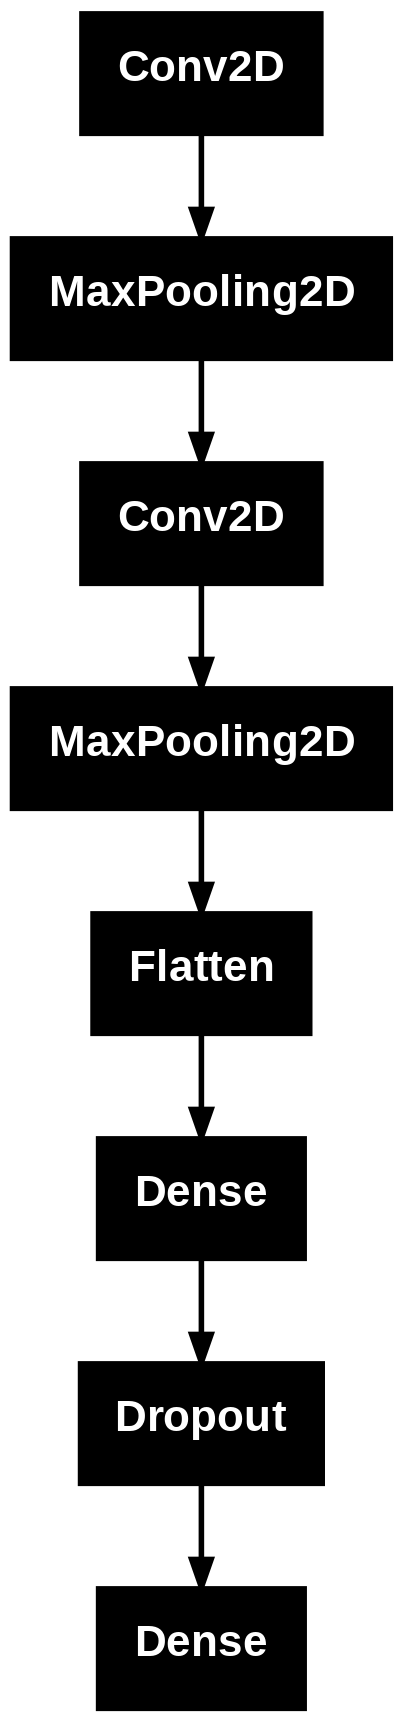

In [ ]:
# 층의 구성을 그림으로 출력
keras.utils.plot_model(model)

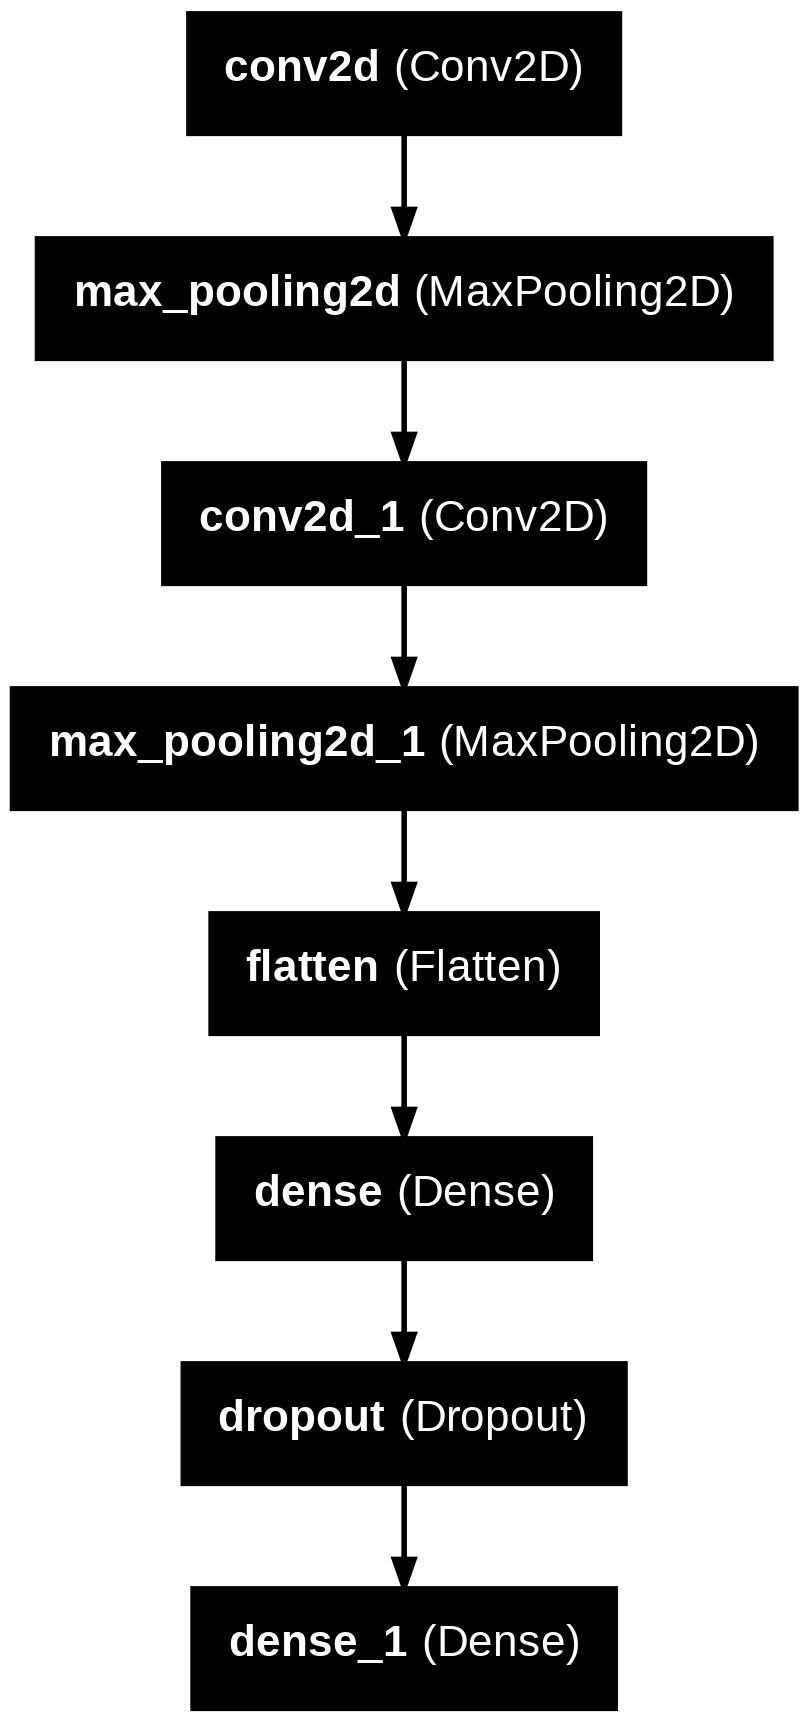

In [ ]:
# 책처럼 층의 이름을 출력하려면
keras.utils.plot_model(model, show_layer_names=True)
# to_file 매개변수에 파일 이름을 지정해 파일로 저장 가능
#keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

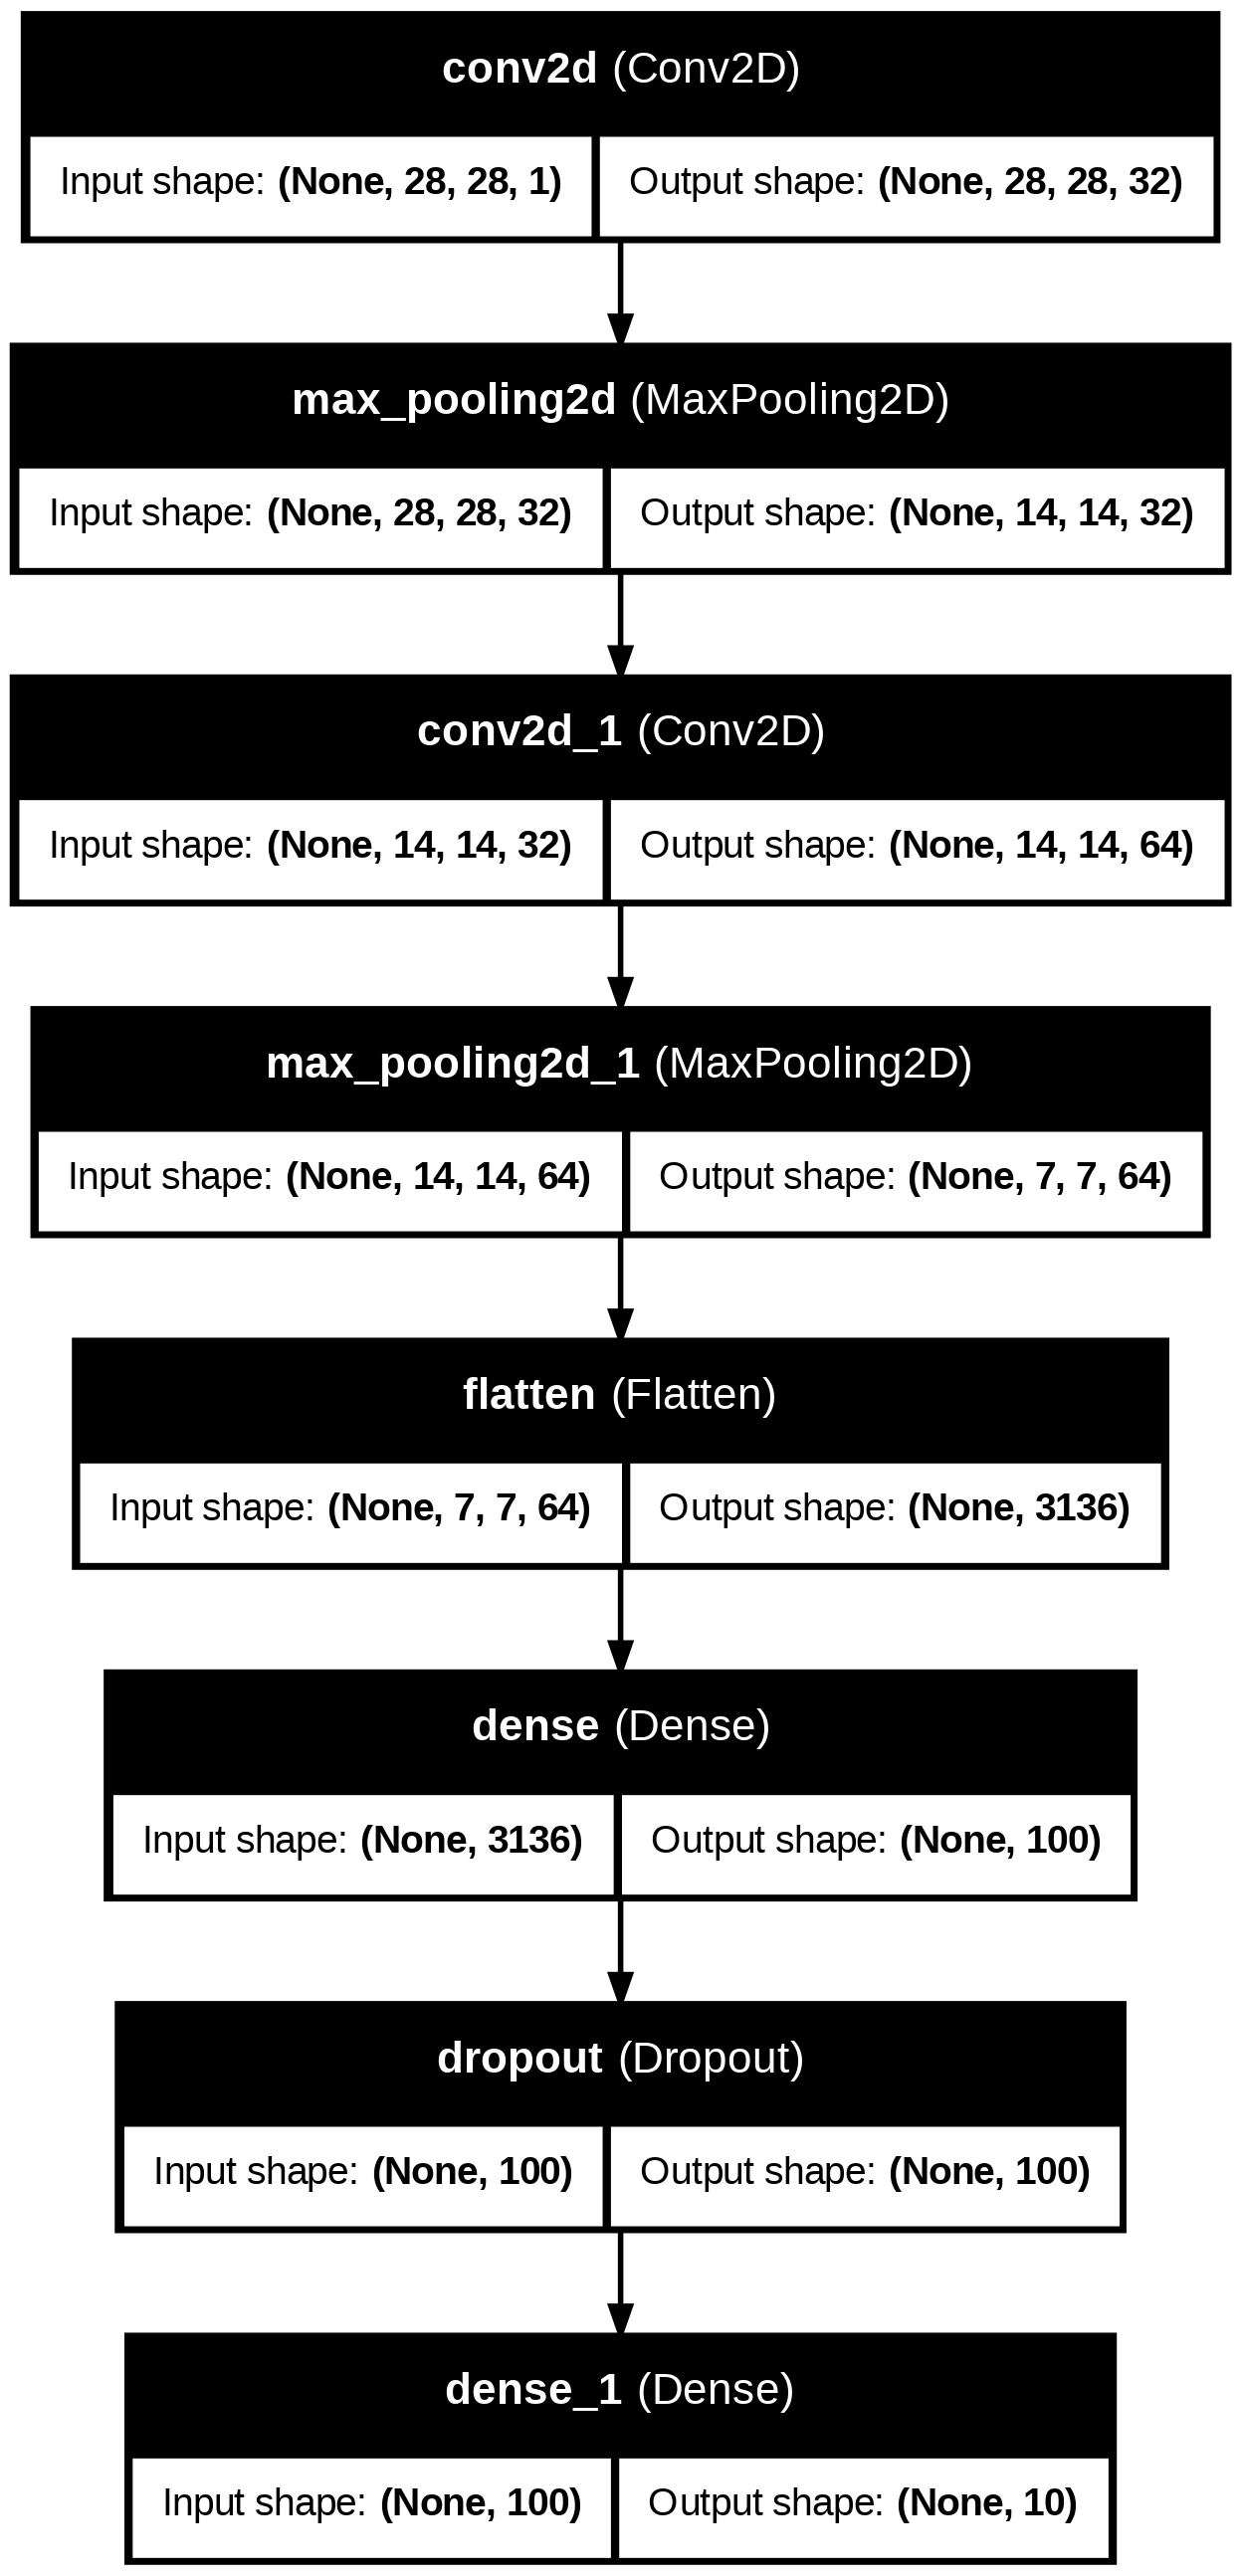

In [ ]:
# 입력과 출력의 크기 표시
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

- Inputlayer가 표시되지 않는 이유: keras 2.0부터 자동으로 생성된 입력층은 명시적으로 표시되지 않도록 변경됨. 표시를 위해서는 Input() 메서드로 입력층을 직접 추가해야함

## 모델 컴파일과 훈련

In [ ]:
# 케라스에서는 딥러닝 모델의 종류나 구성에 상관없이 동일한 컴파일 방식을 사용한다.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Adam 옵티마이저
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras', save_best_only=True)  # 체크포인트 콜백
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)  # 조기 종료 기법
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])  # 훈련 과정

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.7386 - loss: 0.7314 - val_accuracy: 0.8773 - val_loss: 0.3315
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8699 - loss: 0.3620 - val_accuracy: 0.8919 - val_loss: 0.2904
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8923 - loss: 0.3018 - val_accuracy: 0.9016 - val_loss: 0.2634
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9017 - loss: 0.2730 - val_accuracy: 0.9107 - val_loss: 0.2436
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9092 - loss: 0.2529 - val_accuracy: 0.9140 - val_loss: 0.2362
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9220 - loss: 0.2152 - val_accuracy: 0.9185 - val_loss: 0.2212
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9234 - loss: 0.2010 - val_accuracy: 0.9218 - val_loss: 0.2146
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9309 - loss: 0.1906 -

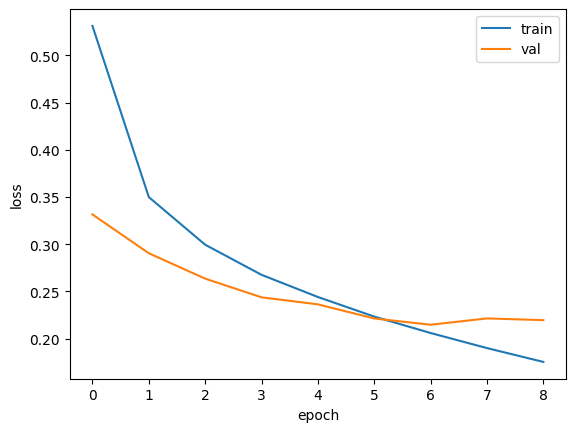

In [ ]:
# 손실 그래프 그리기

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 훈련 세트에 대한 손실이 낮으면서 검증 세트 손실이 증가하지 않은 9번째 에포크가 최적의 성능(실행할 때마다 달라짐)

In [ ]:
# 검증 세트에 대한 성능 평가
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9236 - loss: 0.2099


[0.21460050344467163, 0.921833336353302]

- 9번째 에포크와 동일한 손실을 보임

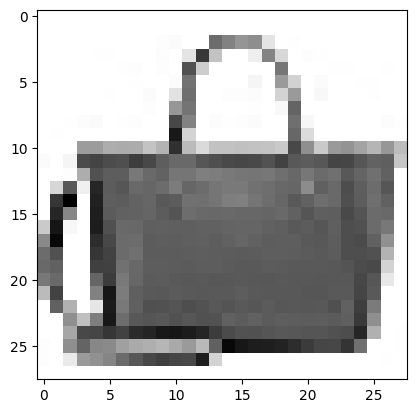

In [ ]:
# 새로운 데이터에 대한 예측 확인하기(검증 세트의 첫 데이터)

plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [ ]:
# 핸드백(가방) 이미지에 대한 예측 출력

preds = model.predict(val_scaled[0:1])  # fit, predict, evaluate은 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대하기 때문에 샘플 하나는 (28, 28, 1)이 아닌 (1, 28, 29, 1)의 크기로 전달해야함
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
[[1.0756417e-16 9.1608098e-24 1.3329631e-20 4.5007382e-16 5.2306534e-17
  3.4106747e-14 3.8421007e-16 2.9828371e-18 1.0000000e+00 1.3635087e-17]]


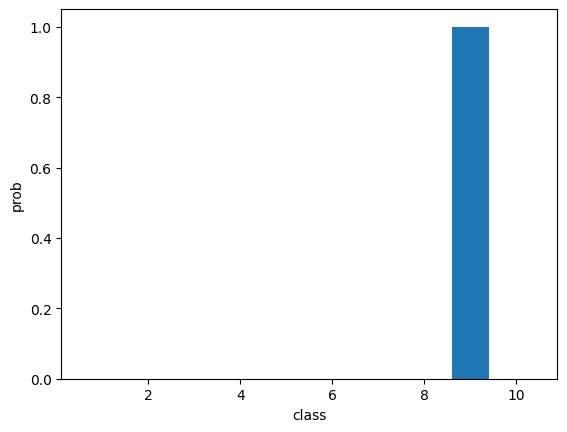

In [ ]:
# 그래프로 확인

plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

- 해당 데이터가 9번째 클래스라고 강하게 예측

In [ ]:
# 아홉번째 클래스를 확인하기 위해 클래스 리스트를 생성하고 레이블 출력

import numpy as np

classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']  # 레이블을 더 직관적으로 표시하기 위함
print(classes[np.argmax(preds)])

가방


In [ ]:
# 처음에 생성한 테스트 세트로 최종 평가

test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0  # 모델에 입력하기 위해 전처리
model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9116 - loss: 0.2449


[0.23558706045150757, 0.914900004863739]

- 91% 이상의 성능을 기대할 수 있음

# 08-03. 합성곱 신경망의 시각화

## 가중치 시각화

In [ ]:
# 모델이 어떤 가중치를 학습했는지 확인하기 위해 체크포인트 파일 불러오기

from tensorflow import keras

model = keras.models.load_model('best-cnn-model.keras')

In [ ]:
# 추가된 층이 리스트 형태로 저장
model.layers

[<Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>]

In [ ]:
# 첫 번째 합성곱 층의 가중치 형태 확인

conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


- 커널의 크기 3x3, 깊이 1, 필터의 개수 32개 / 절편의 개수 32개(필터마다 하나씩 있으므로)

In [ ]:
# 가중치(Tensor객체)를 넘파이 배열로 변환 후 평균과 표준편차 계산

conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.022068808 0.24253985


- 평균값은 0에 가깝고 0.27 정도의 표준편차를 보임

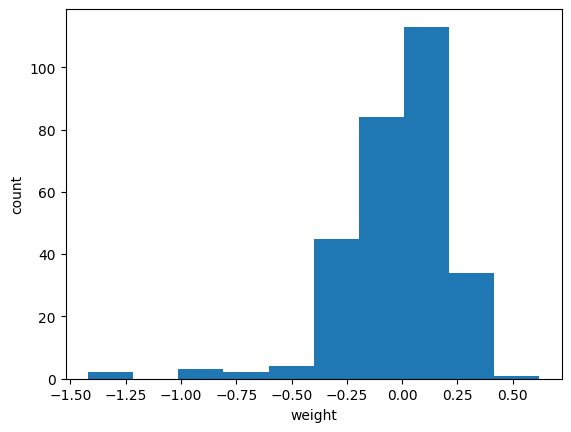

In [ ]:
# 가중치의 분포를 히스토그램으로 그리기

import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))  # 배열을 1차원으로 전달
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

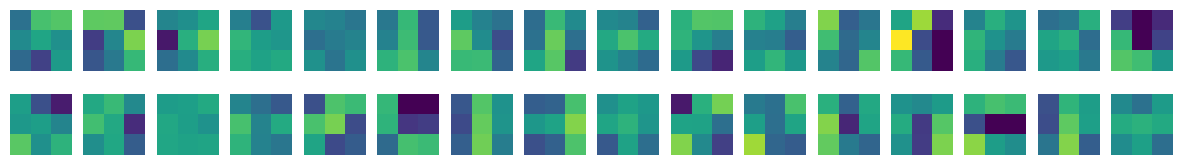

In [ ]:
# 32개의 커널을 출력

fig, axs = plt.subplots(2, 16, figsize=(15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:, :, 0, i*16 + j], vmin=-0.5, vmax=0.5)  # vmin과 vmax로 컬러맵의 범위 지정(밝을수록 높은 가중치)
    axs[i, j].axis('off')
plt.show()

In [ ]:
# 훈련하지 않은 빈 신경망 생성

no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


- 앞의 합성곱 층과 동일한 형태의 가중치

In [ ]:
# 평균과 표준편차 계산

no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(), no_training_weights.std())

0.003249831 0.08214888


- 평균은 동일하게 0에 가깝지만 표준편차가 매우 작음

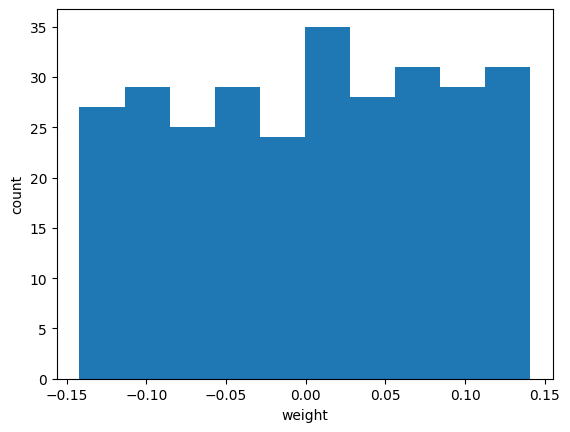

In [ ]:
# 히스토그램으로 표현

plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

- 텐서플로에서 처음 신경망의 가중치를 초기화할 때 균등분포에서 랜덤하게 값을 선택하기 때문에 히스토그램 역시 고른 분포를 보임

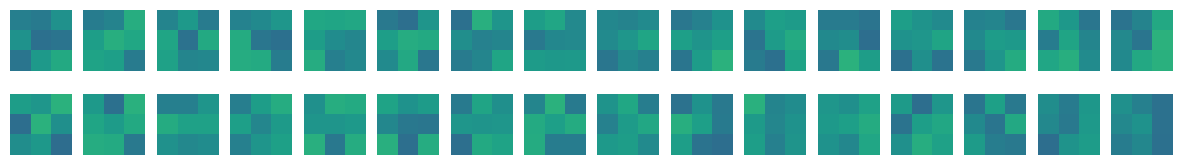

In [ ]:
# 32개의 커널을 출력

fig, axs = plt.subplots(2, 16, figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:, :, 0, i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

- 고르게 분포되어 전체적으로 두드러지는 부분이 보이지 않음

## 함수형 API
- 입력과 출력이 2개 이상일 경우 Sequential 클래스 대신 함수형 API를 사용한다.
- Sequential 클래스는 층이 순차적으로 나열되지만 함수형 API를 사용하면 병렬 연결이나 잔차 연결(입력값과 출력값을 더하여 전달) 등 다양한 형태로 신경망을 구성할 수 있다.
- 케라스에서는 Model 클래스로 구현한다.

### Model 클래스로 함수형 API 구현
- 모든 파이썬 객체는 호출 가능하며 케라스 역시 층을 객체로 호출할 수 있도록 지원한다.
```python
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')

hidden = dense1(inputs)
outputs = dnese2(hidden)
```
해당 코드에서 inputs은 dense1을 거쳐 hidden으로 변환되고 dense2를 거쳐 outputs으로 변환된다.

- Model 클래스에서는 입력층이 자동으로 생성되지 않기 때문에 Input() 메서드를 이용해 직접 추가해야 한다.
```python
inputs = keras.Input(shape=(784,))
```

- 마지막으로 입력과 출력을 Model 클래스로 연결한다.
```python
model = keras.Model(inputs, outputs)
```




In [ ]:
model.input

ValueError: The layer sequential has never been called and thus has no defined input.

- model.input으로 입력하면 해당층이 한번도 호출되지 않았다는 오류 발생
- input 대신 inputs으로 입력해야 정상 출력됨

In [ ]:
# 첫번째 Conv2D의 출력을 반환하는 새로운 모델 생성
conv_acti = keras.Model(model.inputs, model.layers[0].output)

## 특성맵 시각화

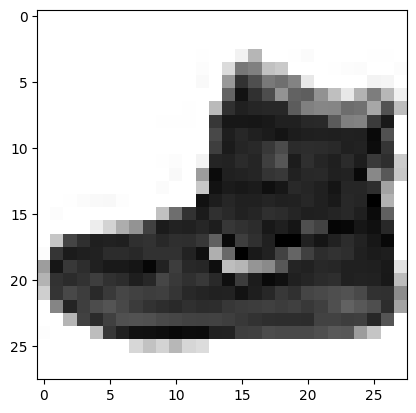

In [ ]:
# 훈련 세트의 첫 번째 샘플 이미지 출력

(train_input, train_target), (test_input, test_target)= keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [ ]:
# 샘플을 입력하고 필터를 통과한 샘플의 특성 맵 형태 출력

inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
(1, 28, 28, 32)


- 배치 차원, 가로, 세로, 32개의 필터

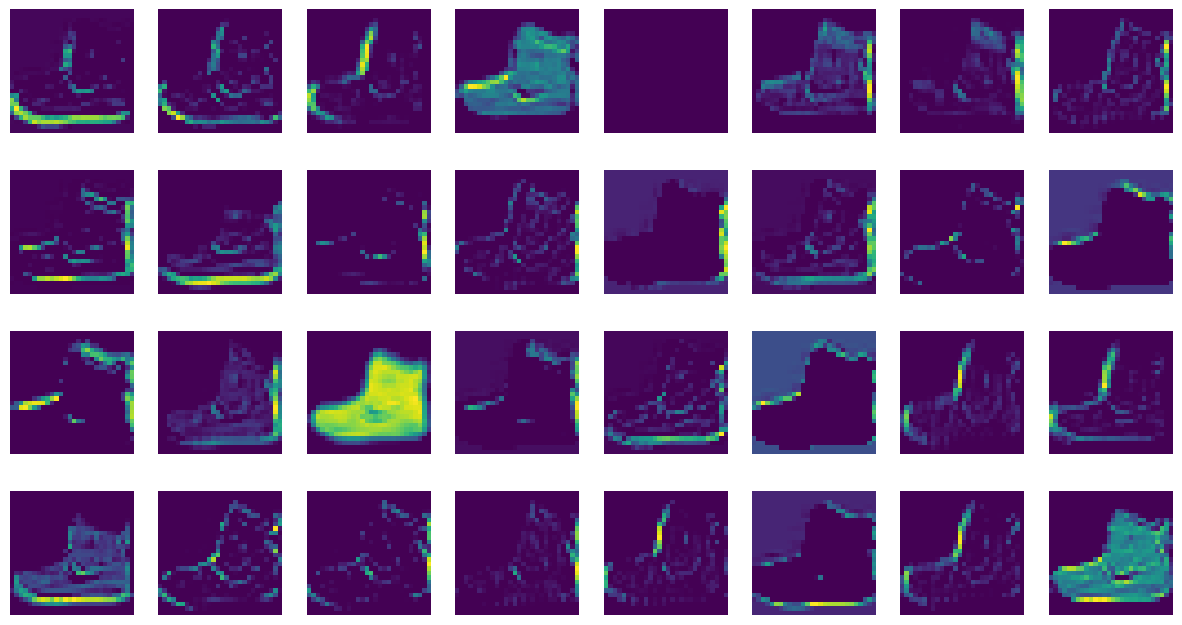

In [ ]:
# 4개의 행에 나누어 32개의 특성 맵 출력

fig, axs = plt.subplots(4, 8, figsize=(15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i*8 + j])
    axs[i, j].axis('off')
plt.show()

- 각 필터가 어느 부분을 감지하고 있는지 확인할 수 있음

In [ ]:
# 두 번째 함성곱 층의 특성 맵 형태 출력

conv2_acti = keras.Model(model.inputs, model.layers[2].output)
#inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)
print(feature_maps.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
(1, 14, 14, 64)


- 첫 번째 풀링 층에 비해 가로세로가 절반으로 줄었고, 필터의 개수는 64개

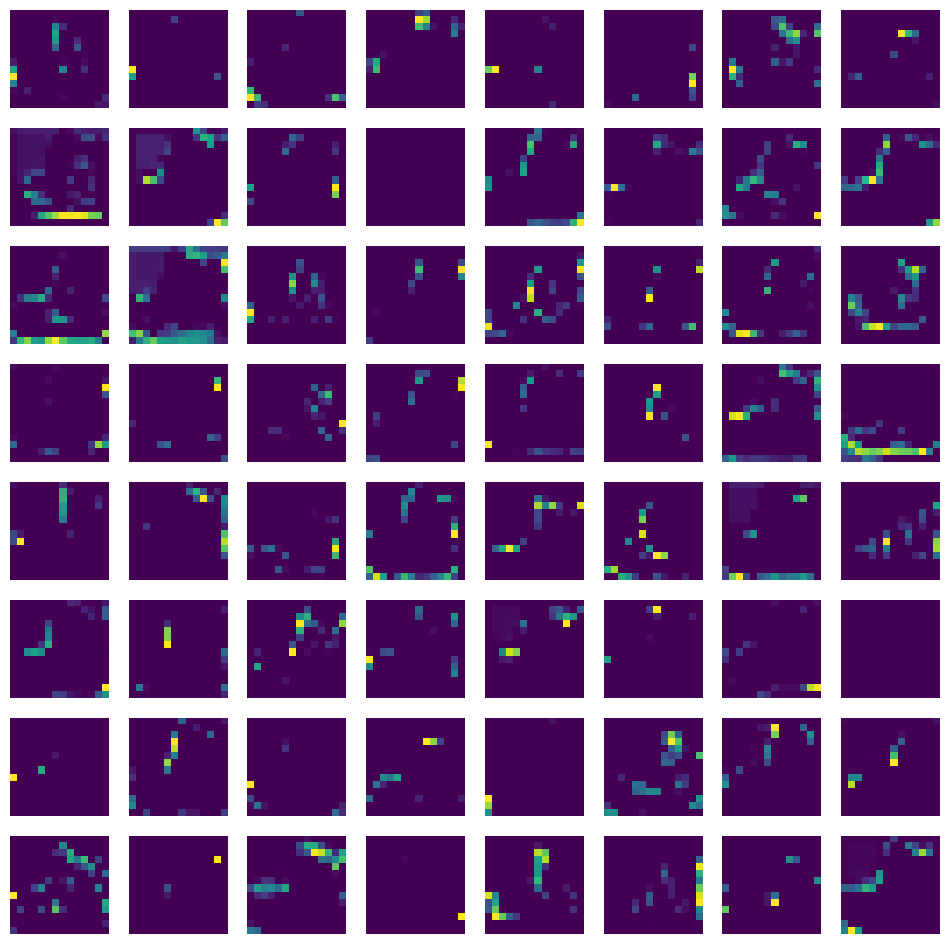

In [ ]:
# 8개의 행에 나누어 64개의 특성 맵 출력

fig, axs = plt.subplots(8, 8, figsize=(12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i*8 + j])
    axs[i, j].axis('off')
plt.show()

- 두 번째 합성곱 층의 필터 크기는 (3, 3, 32)로 이전 32개의 특성 맵의 일부분을 계산한 값이 새로운 특성 맵이 된다.
- 합성곱 층이 누적될수록 특성 맵이 추상화되는 현상이 발생하며 이를 통해 초반의 합성곱 층은 시각적인 정보를 감지하고 뒤로 갈수록 추상적인 정보를 학습함을 알 수 있다.